<a href="https://colab.research.google.com/github/ankurmahesh/noaa_ai_workshop/blob/main/Seasonal_Forecasting_Solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline
import xarray as xr
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import sklearn
import sklearn.ensemble
import scipy.stats
from sklearn.model_selection import train_test_split 
from tqdm import tqdm

This notebook was made by Ankur Mahesh.  Please email mahesh.ankur10@gmail.com if you have any questions!!

In [ ]:
#Download the required packages and the data that we will use 
#for this tutorial

!pip install netCDF4
!wget http://portal.nersc.gov/project/dasrepo/AGU_ML_Tutorial/sst.mon.mean.trefadj.anom.1880to2018.nc
!wget http://portal.nersc.gov/project/dasrepo/AGU_ML_Tutorial/nino34.long.anom.data.txt

     |████████████████████████████████| 4.3MB 4.7MB/s 
     |████████████████████████████████| 296kB 46.8MB/s 
--2020-10-16 14:56:32--  http://portal.nersc.gov/project/dasrepo/AGU_ML_Tutorial/sst.mon.mean.trefadj.anom.1880to2018.nc
Resolving portal.nersc.gov (portal.nersc.gov)... 128.55.206.28, 128.55.206.26
Connecting to portal.nersc.gov (portal.nersc.gov)|128.55.206.28|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://portal.nersc.gov/project/dasrepo/AGU_ML_Tutorial/sst.mon.mean.trefadj.anom.1880to2018.nc [following]
--2020-10-16 14:56:32--  https://portal.nersc.gov/project/dasrepo/AGU_ML_Tutorial/sst.mon.mean.trefadj.anom.1880to2018.nc
Connecting to portal.nersc.gov (portal.nersc.gov)|128.55.206.28|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 432481041 (412M) [application/x-netcdf]
Saving to: ‘sst.mon.mean.trefadj.anom.1880to2018.nc’

sst.mon.mean.trefad 100%[===================>] 412.45M  12.1MB/s    in 27

In [ ]:
!wget http://portal.nersc.gov/project/dasrepo/AGU_ML_Tutorial/regridded_era_t2m.nc

URL transformed to HTTPS due to an HSTS policy
--2020-10-16 14:56:59--  https://portal.nersc.gov/project/dasrepo/AGU_ML_Tutorial/regridded_era_t2m.nc
Resolving portal.nersc.gov (portal.nersc.gov)... 128.55.206.26, 128.55.206.28
Connecting to portal.nersc.gov (portal.nersc.gov)|128.55.206.26|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 257657144 (246M) [application/x-netcdf]
Saving to: ‘regridded_era_t2m.nc’

regridded_era_t2m.n 100%[===================>] 245.72M  18.2MB/s    in 15s     

2020-10-16 14:57:14 (16.3 MB/s) - ‘regridded_era_t2m.nc’ saved [257657144/257657144]



# Logistics

Throughout the tutorial, we will be using directpoll for several participation questions.  Please use this [link](http://etc.ch/Fqun) to vote.  

The results will be displayed on the projector!

# Why Machine Learning?

Chihua or muffin?  

![alt text](https://cdn-media-1.freecodecamp.org/images/1*bt-E2YcPafjiPbZFDMMmNQ.jpeg)

# Machine Learning Fundamentals

In this section, we will cover the fundamentals of machine learning!  We will refer to chapters from Professor Jonathan Shewchuk's excellent lecture notes from CS189 (UC Berkeley's Machine Learning class) as well as course notes developed by TAs including Garrett Thomas and Soroush Nasiriany. These notes provide a rigorous mathematical basis of the foundations of machine learning, and they are very helpful for developing the intuition behind tackling machine learning problems.  If you are interested in going deeper into machine learning, I strongly recommend reading these two resources.

*   Professor Shewchuk's lecture notes can be found at this [link ](https://people.eecs.berkeley.edu/~jrs/papers/machlearn.pdf)
*   Nasiriany and Thomas's course notes can be found at this [link ](http://snasiriany.me/files/ml-book.pdf)

Furthermore, a very useful experiment in machine learning is implementing ML models (decision trees, random forests, logistic regression) from scratch!  While packages such as sklearn have models readily available for you to use, the best learning experience is to implement the models to develop an intuition of what is going on "under the hood."

Throughout the remainder of this notebook, we will cover three topics:
 overfitting, the bias-variance tradeoff, and machine 

1.   How do we validate machine learning models?: Overfitting
2.   How do we improve machine learning models?: Bias-Variance Tradeoff
3.   How do we select machine learning models?: Boosting and Logistic Regression


These topics offer rich examples of **developing intuition**, and these topics have **specific applicability to machine learning in climate** problems.



## The Train/Val/Test Set and Overfitting

A machine learning model uses statistical optimization to learn the relationship between predictors (the input) and predictands (the target).  
*   At this workshop, our predictors have been anomalized global temperature, and our predictand has been the El Nino/ Southern Oscillation (ENSO) 3.4 Index at a lead time.  

Let's call our predictors $X$, and let's call our predictand $y$.  There is some unknown relationship between $X$ and $y$.  For example, there is some unknown function governing the relationship between global temperature and the future ENSO index.  The goal of an ML model is to *approximate* this unknown function.

How do we test if the ML model has correctly approximated this function?  We divide the data into a train set and a test set.


*   During training, the ML model is shown the predictors and their associated predictands.  The ML model uses optimization to learn a function: given the training predictors, the function outputs the predictands as closely as possible.
*   During testing, the ML model is evaluated on unseen data (i.e. the test set). When a model performs well on the training set and poorly on the test, the model has **overfit** to the train set.
*   If a model performs poorly on the training set, this behavior is called **underfitting**.  During underfitting, the model has not learned the correct relationship between the predictors and the predictand.



***POLL QUESTION:*** In the image below, which image corresponds to overfitting? Which corresponds to underfitting? And which corresponds to neither?


![alt text](https://scikit-learn.org/stable/_images/sphx_glr_plot_underfitting_overfitting_001.png)




In the next code cell, let's study overfitting in our ENSO dataset.

In [ ]:
#Scaffold code to load in data.  This code cell is mostly data wrangling
#Feel free to peruse at your leisure.

def load_enso_indices():
  """
  Reads in the txt data file to output a pandas Series of ENSO vals

  outputs
  -------

    pd.Series : monthly ENSO values starting from 1870-01-01
  """
  with open('nino34.long.anom.data.txt') as f:
    line = f.readline()
    enso_vals = []
    while line:
        yearly_enso_vals = map(float, line.split()[1:])
        enso_vals.extend(yearly_enso_vals)
        line = f.readline()

  enso_vals = pd.Series(enso_vals)
  enso_vals.index = pd.date_range('1870-01-01',freq='MS',
                                  periods=len(enso_vals))
  enso_vals.index = pd.to_datetime(enso_vals.index)
  return enso_vals

def assemble_predictors_predictands(start_date, end_date, lead_time, 
                                    use_pca=False, n_components=32):
  """
  inputs
  ------

      start_date        str : the start date from which to extract sst
      end_date          str : the end date 
      lead_time         str : the number of months between each sst
                              value and the target Nino3.4 Index
      use_pca          bool : whether or not to apply principal components
                              analysis to the sst field
      n_components      int : the number of components to use for PCA

  outputs
  -------
      Returns a tuple of the predictors (np array of sst temperature anomalies) 
      and the predictands (np array the ENSO index at the specified lead time).

  """
  ds = xr.open_dataset('sst.mon.mean.trefadj.anom.1880to2018.nc')
  sst = ds['sst'].sel(time=slice(start_date, end_date))
  num_time_steps = sst.shape[0]
  
  #sst is a 3D array: (time_steps, lat, lon)
  #in this tutorial, we will not be using ML models that take
  #advantage of the spatial nature of global temperature
  #therefore, we reshape sst into a 2D array: (time_steps, lat*lon)
  #(At each time step, there are lat*lon predictors)
  sst = sst.values.reshape(num_time_steps, -1)
  sst[np.isnan(sst)] = 0

  #Use Principal Components Analysis, also called
  #Empirical Orthogonal Functions, to reduce the
  #dimensionality of the array
  if use_pca:
    pca = sklearn.decomposition.PCA(n_components=n_components)
    pca.fit(sst)
    X = pca.transform(sst)
  else:
    X = sst

  start_date_plus_lead = pd.to_datetime(start_date) + \
                        pd.DateOffset(months=lead_time)
  end_date_plus_lead = pd.to_datetime(end_date) + \
                      pd.DateOffset(months=lead_time)
  y = load_enso_indices()[slice(start_date_plus_lead, 
                                end_date_plus_lead)]


  ds.close()
  return X, y

def plot_nino_time_series(y, predictions, title):
  """
  inputs
  ------
    y           pd.Series : time series of the true Nino index
    predictions np.array  : time series of the predicted Nino index (same
                            length and time as y)
    titile                : the title of the plot

  outputs
  -------
    None.  Displays the plot
  """
  predictions = pd.Series(predictions, index=y.index)
  predictions = predictions.sort_index()
  y = y.sort_index()

  plt.plot(y, label='Ground Truth')
  plt.plot(predictions, '--', label='ML Predictions')
  plt.legend(loc='best')
  plt.title(title)
  plt.ylabel('Nino3.4 Index')
  plt.xlabel('Date')
  plt.show()
  plt.close()


The code cell below demonstrates overfitting: getting great performance on the train set.
For an absurd lead time (36 months!!), it is possible to get a perfect ENSO forecast on the train set.  Such accurate forecasting at such large lead times is almost certainly impossible.


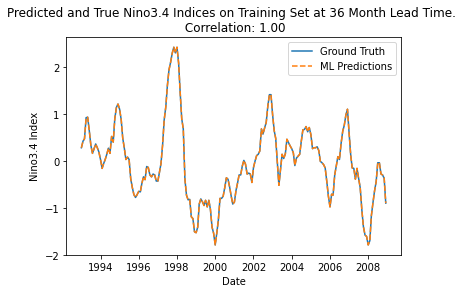

In [ ]:
#Load in the predictors
X, y = assemble_predictors_predictands('1990-01-01','2005-12-31', 36)

#Let's use a linear regression model
regr = sklearn.linear_model.LinearRegression()
regr.fit(X,y)

predictions = regr.predict(X)
corr, _ = scipy.stats.pearsonr(predictions, y)

plot_nino_time_series(y, predictions, 
    'Predicted and True Nino3.4 Indices on Training Set at 36 Month Lead Time. \n Correlation: {:.2f}'.format(corr))

The cell above shows that getting great train-set performance is possible, even for a very tough task (36 month ahead Nino forecast).
We need to evaluate the model on unseen data to see if it can **generalize** well: this is why a test set is so crucial!




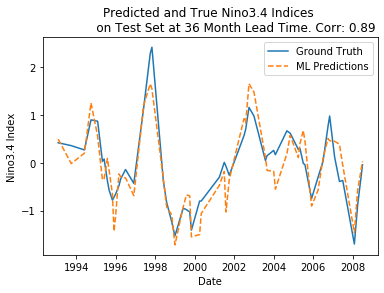

In [ ]:
"""Evaluate the model on a randomly selected test set"""
#X has shape (num_time_steps, lat*lon)
#y has shape (num_time_steps)
np.random.seed(0)

#Randomly shuffle X and y to split them in a train and test set
num_time_steps = X.shape[0]
permuted_indices = np.random.permutation(np.arange(num_time_steps))

#Keep 70% of the data for the test set
train_set_proportion = int(0.7 * num_time_steps)
X, y = X[permuted_indices], y[permuted_indices]
X_train, y_train = X[:train_set_proportion], y[:train_set_proportion]
X_test, y_test = X[train_set_proportion:], y[train_set_proportion:]

#Instead of writing the above logic yourself, sklearn also provides
#a built-in method in the line below.
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
regr = sklearn.linear_model.LinearRegression()
regr.fit(X_train,y_train)

predictions_test = regr.predict(X_test)
corr, _ = scipy.stats.pearsonr(predictions_test, y_test)

plot_nino_time_series(y_test, predictions_test,
            'Predicted and True Nino3.4 Indices \n \
            on Test Set at 36 Month Lead Time. Corr: {:.2f}'.format(corr))

WHOA?! What happened above? Did we just develop a 36-month ahead forecast that has 0.81 correlation on unseen data?? 

Randomly splitting time series data into a train set and a test set is very risky. In many climate datasets, time series have a non-neglible auto-correlation.  Think of it like this: the atmosphere usually has a "memory" of about 14 days, and the ocean roughly has a "memory" of about 2 years.  

If we randomly split the dataset into train set and test set, some of the examples in the test set will be correlated with examples in the train set.  **This corrupts our test set.** If the test set is correlated with the train set, then it no longer measures how generalizable our ML model is.

**CODING EXERCISE** In the cell below, write code to evaluate the model on a true uncorrelated test set.

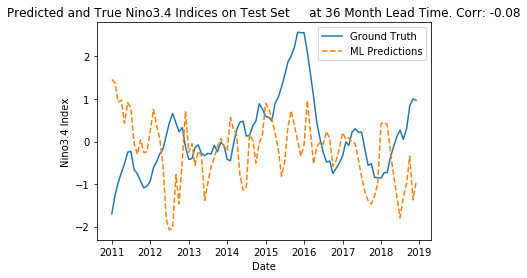

In [ ]:
X_test, y_test = assemble_predictors_predictands('2008-01-01','2015-12-31',36)

predictions_test = regr.predict(X_test)
corr, _ = scipy.stats.pearsonr(predictions_test, y_test)
plot_nino_time_series(y_test, predictions_test,
    'Predicted and True Nino3.4 Indices on Test Set \
    at 36 Month Lead Time. Corr: {:.2f}'.format(corr))

This makes more sense.  On a true test set, our model making *36 month ahead* predictions does not generalize well.

***CODING EXERCISE*** Using the code samples above as a starting point, in the following cell, write code to calculate and plot the performance of the model at different lead times.

100%|██████████| 15/15 [00:29<00:00,  1.96s/it]


Text(0, 0.5, 'Correlation')

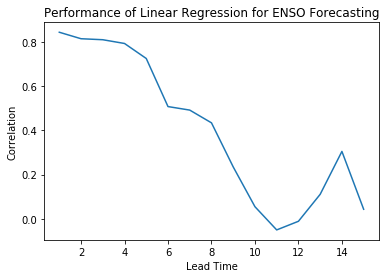

In [ ]:
"""Plot the performance of linear regression-based ENSO forecasting at
different lead times"""
#the keys of the dictionary are the lead time, and the values are the 
#correlation between linear regression forecasts and the truth
lead_time_to_corr_dict = {}

#tqdm handles showing the progress bar
for lead_time in tqdm(range(1,16,1)):
  X_train, y_train = assemble_predictors_predictands('1990-01-01','2005-12-31',
                                                     lead_time)
  X_test, y_test = assemble_predictors_predictands('2008-01-01','2015-12-31', 
                                                 lead_time)

  regr = sklearn.linear_model.LinearRegression()
  regr.fit(X_train,y_train)

  predictions_test = regr.predict(X_test)
  corr, _ = scipy.stats.pearsonr(predictions_test, y_test)
  lead_time_to_corr_dict[lead_time] = corr

plt.plot(list(lead_time_to_corr_dict.keys()), 
         list(lead_time_to_corr_dict.values()))
plt.title('Performance of Linear Regression for ENSO Forecasting')
plt.xlabel('Lead Time')
plt.ylabel('Correlation')
plt.show()

**TAKE HOME EXERCISE** Calculate and plot the performance of the model with different size training datasets

## The Bias-Variance Tradeoff

### Introduction and Theory

The behavior of machine learning models can be decomposed into two quantities:

*   **Bias**: On the training set, how well does the machine learning model predict the truth?
*   **Variance**: As the input data varies, how does the machine learning prediction vary?  For a small change in the input predictors, how much would the ML prediction change? 

Let's look at the earlier figure once again:
![alt text](https://scikit-learn.org/stable/_images/sphx_glr_plot_underfitting_overfitting_001.png)


The left image uses a linear model to approximate a nonlinear "true function".  Therefore, the linear model does not understand the function well, and it has high bias.  Similarly, it has low variance, because small changes to sample points along the curve will not change the linear model must.


***Polling question*** 
1. Does the right image have high or low bias?
2. Does the right image have high or low variance?


Based on the figures above, we conclude that bias and variance are often a tradeoff: models with high bias often have low variance, and vice versa.  See page 23 of Nasiriany's notes for a mathematical derivation of this tradeoff.


Here's another example to help develop our visual understanding of bias vs. variance.

Here is how a k-Nearest-Neighbor model works:
1. The model is shown a sample data point from the test set, $x_\text{test}$
2. It searches its training set for the $k$ most similar data points
3. Of the $k$ points it founds, it calculates the most common predictand, and it assigns $x_\text{test}$ the most common 

Crucially, this method supports classification of data that is not linearly separable (see below image for an example)

***Polling question:*** For different values of $k$, would you expect a high bias/low variance classifier? Or a high variance/low bias classifier?

![alt text](https://cse3521.artifice.cc/images/effect-of-k.png)




Let's connect the bias/variance tradeoff to the discussion we had on overfitting in the first section. Implications of the bias-variance tradeoff (from Wikipedia)
 
*   "The bias error is an error from erroneous assumptions in the learning algorithm. High bias can cause an algorithm to miss the relevant relations between features and target outputs (**underfitting**)."

*   "The variance is an error from sensitivity to small fluctuations in the training set. High variance can cause an algorithm to model the random noise in the training data, rather than the intended outputs (**overfitting**)."

### Regularization

Our goal in machine learning is to avoid underfitting and overfitting: we want to develop models that perform well in both the train set and the test set.

One method to avoid overfitting is **regularization.** In the next section, we will discuss how regularization avoids overfitting.  

Let $X$ be a 2D matrix of shape $(n,d)$ where $n$ is the number of time steps and $d$ is the number of predictors.  Let $y$ be a vector of shape $(n,1)$ that has the target ENSO values.  Let $w$ be a vector of shape $(d,1)$

In ordinary least squares linear regression, we are **finding the value of $w$** that minimizes the following term: 

$$\text{min}||Xw-y||^2 $$


Here's an intuitive description of the math above: 
*   the goal of linear regression is to minimize the squared difference between the linear models' predictions ($Xw$) and the truth ($y$).

The forecast of a linear regression model is $Xw$.  Here's an intuitive description of what $Xw$: 
*   a linear regression model makes a forecast by multiplying each predictor by its associated weight and returning the sum of these products. With  large weights, a small change in one of the predictors will lead to a large change in the forecast.  Therefore, we amend linear regression to penalize the model from learning large weights:


$$\text{min}||Xw-y||^2 + \alpha ||w||^2 $$


$\alpha ||w||^2$ is called a regularization term. This regularized form of linear regression is often called **Ridge Regression**.

Please see pg. 6 of Nasiriany for mathematical derivations to the solutions of the above two minimization problems.


### *Coding Problem*: Regularization


In this example, we will investigate the real-world effect of regularization on our ENSO dataset. 

Note: for visualization purposes, we do not train our models using all lat$*$lon predictors.  Instead, we use Principal Components Analysis (aka Empirical Orthogonal Functionals) to represent all lat$*$lon predictors with far fewer dimensions.  Due to time constraints, please refer to page 116 of Professor Shewchuk's notes for a deeper explanation of this method.

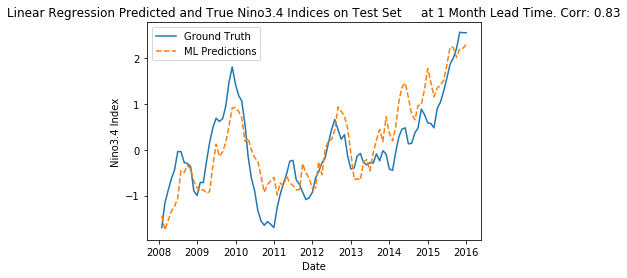

In [ ]:
"""Plot the performance of linear regression at 1 month ahead lead time"""
X_train, y_train = assemble_predictors_predictands('1990-01-01','2005-12-31', 
                                                1,use_pca=True)
X_test, y_test = assemble_predictors_predictands('2008-01-01','2015-12-31', 1,
                                                  use_pca=True)

#1 month linear regression (lr) model
regr_1_month_lr = sklearn.linear_model.LinearRegression()
regr_1_month_lr.fit(X_train,y_train)

predictions_test = regr_1_month_lr.predict(X_test)
corr, _ = scipy.stats.pearsonr(predictions_test, y_test)
plot_nino_time_series(y_test, predictions_test,
    'Linear Regression Predicted and True Nino3.4 Indices on Test Set \
    at 1 Month Lead Time. Corr: {:.2f}'.format(corr))


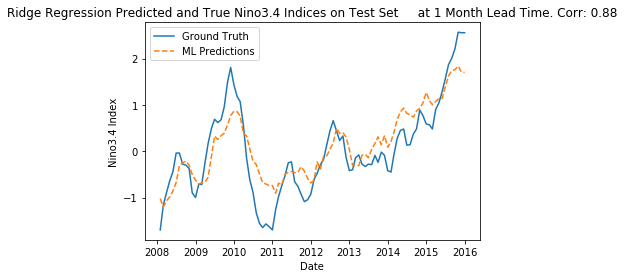

In [ ]:
"""Plot the performance of ridge regression at 1 month ahead lead time"""
X_train, y_train = assemble_predictors_predictands('1990-01-01','2005-12-31', 
                                                1,use_pca=True)
X_test, y_test = assemble_predictors_predictands('2008-01-01','2015-12-31', 1,
                                                  use_pca=True)

#1 month ridge regression model
regr_1_month_ridge = sklearn.linear_model.Ridge(alpha=80000.0)
regr_1_month_ridge.fit(X_train,y_train)

#First, let's plot the performance of the model
predictions_test = regr_1_month_ridge.predict(X_test)
corr, _ = scipy.stats.pearsonr(predictions_test, y_test)
plot_nino_time_series(y_test, predictions_test,
    'Ridge Regression Predicted and True Nino3.4 Indices on Test Set \
    at 1 Month Lead Time. Corr: {:.2f}'.format(corr))


WOOHOO! Right off the bat, on the test set we see that the regularized model performs slightly better than the linear model! This is a good sign, as the goal of regularization is to develop models that can better **generalize** to unseen data.

Next, let's visualize and compare the variance of the two models.  Recall that models that are highly variable are susceptable to small fluctuations in the predictors.  In the code cell below, we conduct the experiment:


*   Perturb the test set predictors by multiplying them by a random number between -1.05 and 1.05
*   Run the trained ridge regression and linear regression models on those perturbed predictors
*   Record the spread in the predictions

The spread of these predictions is the variance of the ML model.

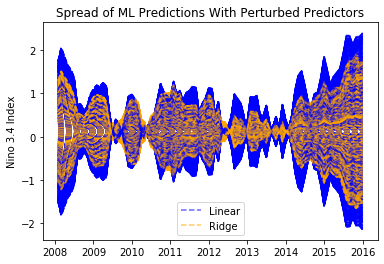

In [ ]:
"""In this cell, we will visualize the variance of linear regression and ridge regression"""
for experiment_num in range(1000):
  perturbed_X_test = X_test * np.random.uniform(-1.05,1.05)
  
  perturbed_predictions_linear = regr_1_month_lr.predict(perturbed_X_test)
  perturbed_predictions_linear = pd.Series(perturbed_predictions_linear,
                                           index=y_test.index)
  plt.plot(perturbed_predictions_linear, '--', label='Linear', color='blue',
           alpha=0.6)

  perturbed_predictions_ridge = regr_1_month_ridge.predict(perturbed_X_test)
  perturbed_predictions_ridge = pd.Series(perturbed_predictions_ridge,
                                           index=y_test.index)
  plt.plot(perturbed_predictions_ridge, '--', label='Ridge', color='orange',
           alpha=0.6)

  if experiment_num == 0: plt.legend(loc='best')

plt.title("Spread of ML Predictions With Perturbed Predictors")
plt.ylabel("Nino 3.4 Index")
plt.show()

The plot above illustrates the effect of regularization!  When randomly perturbing the input 1000 times, the predictions from linear regression (blue) have a larger spread than those from ridge regression (orange).  This means that linear regression has a higher variance than ridge regression.  

In the cell below, let's investigate why ridge regression is less vulnerable to small fluctuations in the data.

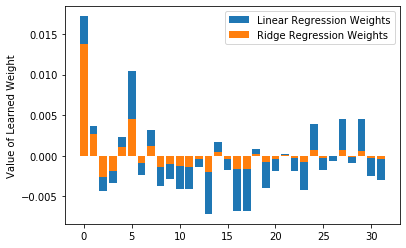

In [ ]:
"""In this cell, we will visualize how the weights of the linear 
regression model are bigger than those of the ridge regression model"""

regr_1_month_lr_weights = regr_1_month_lr.coef_
regr_1_month_ridge_weights = regr_1_month_ridge.coef_

plt.bar(range(regr_1_month_lr_weights.shape[0]), regr_1_month_lr_weights,
        label='Linear Regression Weights')
plt.bar(range(regr_1_month_ridge_weights.shape[0]), regr_1_month_ridge_weights,
        label='Ridge Regression Weights')
plt.legend(loc='best')
plt.ylabel('Value of Learned Weight')
plt.title('Comparison of the Size of Weights of Linear and Ridge Regressio')
plt.show()

As expected, the weights of the ridge regression model are smaller than those of the linear regression model. 

There we have it! On our real-world ENSO dataset, we have confirmed our theoretical speculations about the effect of regularization on the bias-variance tradeoff!   

To recap:

*   Because of the regularization term, the weights in a ridge regression model are smaller (large weights are penalized during the optimization) than those in linear regression
*   With smaller weights, the ridge regression model is less vulnerable to small fluctuations in the data
*   This means that ridge regression models have less variance and are less vulnerable to overfitting

## Machine Learning Models and Model Selection

### Potpourri Polling Project 1: Variance Scaling

In the preprocessing presentation, we discussed ways that data is normalized before being fed into machine learning models.  Some models ML techniques require data to be centered (have mean 0); in other cases, normalization helps with numerical stability.  

One type of normalization is called variance scaling.  Variance scaling is to scale the variance of each predictor such that each predictor has a variance of 1.  

In our ENSO dataset, we have latxlon predictors; each predictor is temperature at a certain location on Earth.  We have ```num_time_steps``` samples of these predictors. Therefore, the shape of ```X``` is (num_time_steps, latxlon). *Variance scaling would mean that we scale our dataset such that the variance of temperature at each grid cell is 1.*

**Polling Question:** we use variance scaling for our ENSO forecasting model?

Acknowledgment: I'd like to  thank Professor [Patrick Brown](https://patricktbrown.org/about/) for helping me with this problem. 

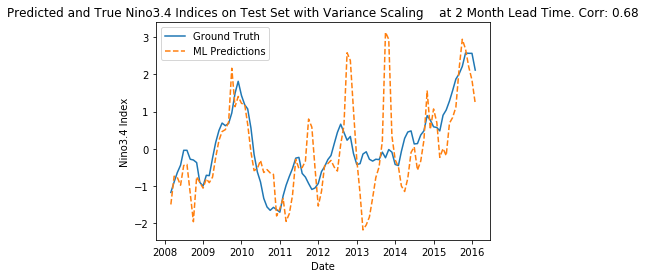

In [ ]:
"""Plot the linear regression predictions when the input data has been variance
scaled"""
X_train, y_train = assemble_predictors_predictands('1980-01-01','2005-12-31', 
                                                2)
X_test, y_test = assemble_predictors_predictands('2008-01-01','2015-12-31', 2)

#StandardScaler(with_mean=False) learns a transformation that scales
#the data such that its standard deviation is 1. Setting
#with_mean to True also centers the data so that it has mean 0. Try it out!
scaler = sklearn.preprocessing.StandardScaler(with_mean=False)
X_train = scaler.fit_transform(X_train)

#IMPORTANT: Note that the test data must be completely unseen! Therefore, we cannot
#use it to learn how to scale data; we cannot scale the train and test 
#data at once.  That would corrupt our test dataset, as the train dataset
#would be scaled based on properties from the test dataset.
#Instead, we use a variance scaling transformation on the training set, 
#and apply that same transformation to the test set.
X_test = scaler.transform(X_test)

#1 month linear regression (lr) model
regr_1_month_lr_var_scale = sklearn.linear_model.LinearRegression()
regr_1_month_lr_var_scale.fit(X_train,y_train)

#First, let's plot the performance of the model
predictions_test = regr_1_month_lr_var_scale.predict(X_test)
corr, _ = scipy.stats.pearsonr(predictions_test, y_test)
plot_nino_time_series(y_test, predictions_test,
    'Predicted and True Nino3.4 Indices on Test Set with Variance Scaling\
    at 2 Month Lead Time. Corr: {:.2f}'.format(corr))

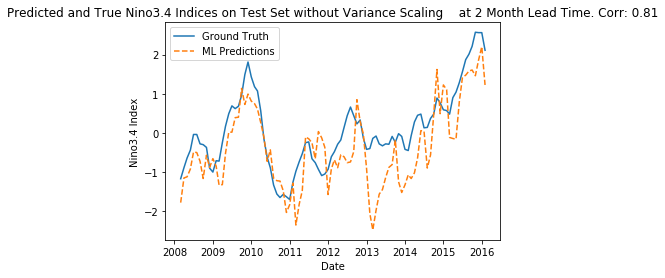

In [ ]:
"""Plot the linear regression predictions when the input data has not been variance
scaled"""
X_train, y_train = assemble_predictors_predictands('1980-01-01','2005-12-31', 2)
X_test, y_test = assemble_predictors_predictands('2008-01-01','2015-12-31', 2)

#1 month linear regression (lr) model
regr_1_month_lr = sklearn.linear_model.LinearRegression()
regr_1_month_lr.fit(X_train,y_train)

#First, let's plot the performance of the model
predictions_test = regr_1_month_lr.predict(X_test)
corr, _ = scipy.stats.pearsonr(predictions_test, y_test)
plot_nino_time_series(y_test, predictions_test,
    'Predicted and True Nino3.4 Indices on Test Set without Variance Scaling\
    at 2 Month Lead Time. Corr: {:.2f}'.format(corr))

What's going on here? Why does variance scaling adversely affect performance?

Here is a *theory* about why this is happening: our predictors correspond to real temperature at latitude/ longitude grid cells.  Grid cells with constant latitude and longitude are of very different sizes! 1 degree x 1 degree at the poles is much smaller than 1 degree x 1 degree at the equator. Therefore, grid cells closer to the poles are more noisier and have more variance.  This is important for an ENSO forecasting model to take into account!  If we scale variance, the larger grid cells lose their comparative advantage in predictive power to smaller grid cells, and the machine learning model does worse.

This example illustrates how to tackle problems at the ***intersection*** of machine learning and climate.  We must use intuition and theory of both fields to pose experiments and analyze results.

Do you have any other ideas? I'd be very curious to hear them!!

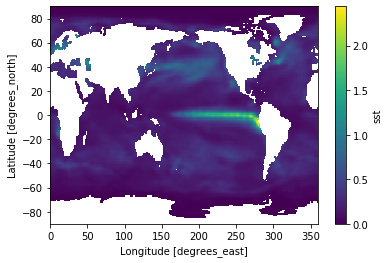

In [ ]:
"""Plot the variance of SST anomalies at each grid cell"""

ds = xr.open_dataset('sst.mon.mean.trefadj.anom.1880to2018.nc')
sst = ds['sst'].sel(time=slice("1980-01-01","2005-12-31"))
sst_var = sst.std(axis=0)**2

sst_var.plot()


### Potpourri Polling Project : Tides

Let's say we are using a linear model to classify high tide or low tide. At a certain location, we observe the following pattern. In our entire dataset, there is 1 tide height spike per day; it starts a few minutes before noon and ends a few minutes after noon. The rest of the day, tide remains relatively constant at low tide. To improve the accuracy of our classifier, we add the timestamp of the observed tide, stored as the number of seconds since the previous noon, as an additional input predictor to the model. However, this barely helps the classifier. What is going wrong? 

What can we do to improve our results?


*   A. Change the reference time frame
*   B. Use a non-linear model
*   C. There is a class imbalance.  Get more training data!
*   D. There could be a confounding variable, and time is not a good predictor for the model







# Essential Reading Material After This Tutorial

To supplement this tutorial, I have included topics on traditional machine learning that I think are crucial for all ML practitioners in climate science to know.  

1. What is boosting? Why is it necessary and how does it help? (Prof. Shewchuk pg. 147, Nasiriany pg. 169) 

2. How do traditional ML models work? Logistic regression (Nasiriany pg. 113), random forests (Nasiriany pg. 163), and support vector machines (Nasiriany pg. 127)

3. What strategies help alleviate challenges of data being linearly inseparable? (Professor Shewchuk pg. 20) What is the kernel trick? How does it help with this challenge? (Prof. Shewchuk pg. 76)

4. Gradient Descent and Newton's method (Nasiriany pg. 82 and 93)

# 4 Take Home problems:

1. Add OHC as a predictor.  You can download OHC data from the GODAS reanalysis.  Does OHC improve the quality of your ENSO forecasts? Based on the answer to the previous question, what doe this tell you about the bias and variance of your OHC model?

2. Forecast ENSO with deep learning!  In the next section, Mayur Mudigonda will give an intro to deep learning and convolutional neural networks.  Using your knowledge from his presentation, try to forecast ENSO with deep learning! How does the performance of deep learning compare to linear regression? (Use the ```assemble_predictors_predictands ``` method in this notebook to handle loading in the predictors and predictands for a lead time of your choice) How far ahead can you forecast?

3. Classification vs. Regression!  In this notebook, we treated ENSO forecasting as a regression problem.  When the Nino3.4 Index is above 0.5 for 5 consecutive months, then there is an El Nino. When the Nino3.4 Index is below 0.5 for 5 consecutive months, then there is an La Nina. The lines of code below implement this labelling.
```
_, y = assemble_predictors_predictands('1990-01-01','2005-12-31',1)
y_el_nino_binary = (y > 0.5).rolling(window=5).min()
y_la_nina_binary = (y < 0.5).rolling(window=5).min()
y_classification = pd.Series(np.zeros(y_el_nino_binary.shape),
                        index=y.index)
y_classification[y_el_nino_binary == 1.0] = 2 
y_classification[y_la_nina_binary == 1.0] = 1                   
```
```y_classification``` has three values (2,1,0), indicating if the event is El Nino, La Nina, or neither.  In this notebook, we have treated ```y``` has a continuous value.  If we treat it as a discrete value, can we use linear classifiers to forecast ENSO more accurately? If we treat it as a discrete value, can we use deep learning classifiers to forecast ENSO more accurately?

4. Read about decision trees and random forests on page 163 of Nasiriany's notes and 81 of Professor Shewchuk's notes.  Compare the minimization problem of linear regression to that of random forests.  Implement a decision tree and a random forest from scratch.  Using the decision tree and the random forest that you implement, try to forecast ENSO! How do these models perform compare to the models we used in this tutorial?
